In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold, GridSearchCV, cross_val_predict
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Para que no aparezcan advertencias no deseadas
import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv("data/winequality-red.csv", sep=";")
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


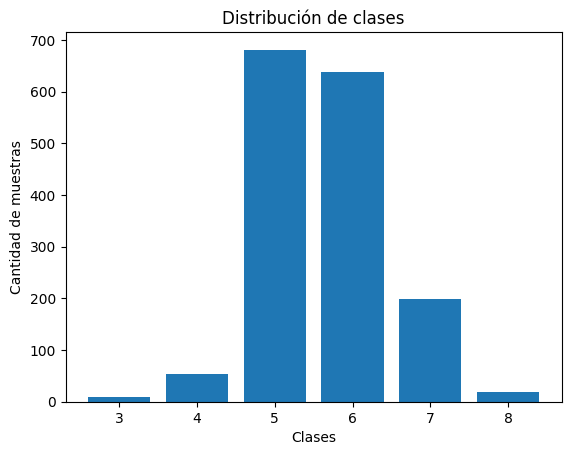

In [16]:
X = df.drop("quality", axis=1)
y = df["quality"]

clases = y.unique()
clases.sort()
#Muestra del balance de datos

muestra = pd.DataFrame()
muestra["Clases"] = clases
muestra["Cantidad"] = y.value_counts().sort_index().values

plt.bar(muestra["Clases"], muestra["Cantidad"])
plt.title("Distribución de clases")
plt.xlabel("Clases")
plt.ylabel("Cantidad de muestras")
plt.show()

In [68]:
muestra

,Clases,Cantidad
0,3,10
1,4,53
2,5,681
3,6,638
4,7,199
5,8,18


Notamos que las clases estan desbalanceadas para su análisis. Esto podrá afectar una futura clasificación. Procedemos a realizar un análisis con los datos de manera fiel y luego, realizar una nueva clasificación de vinos con una reducción de categorías/niveles para mejorar el trabajo con el data set brindado

Como trabajamos con un set de datos pequeño, usaremos validación cruzada en la selección de grupos para buscar obtener la mejor predicción posible. Esto es porque train_test_split realiza asignaciones aleatorias, lo que puede dejar fuera clases con pocas observaciones

In [49]:
#Identificamos mejores parámetros para RanfomForest

model = RandomForestClassifier(random_state=42)

parametro = {
    'n_estimators' : [50, 100, 200],
    'max_depth' : [5,10,15],
    'min_samples_split' : [2,5,10]
}

mi_grid = GridSearchCV(estimator = model, 
                       param_grid = parametro, 
                       cv = 5, 
                       scoring='accuracy')

mi_grid.fit(X,y)

print("mejores parametros: ", mi_grid.best_params_)
print("mejor score: ", mi_grid.best_score_)


mejores parametros:  {'max_depth': 5, 'min_samples_split': 5, 'n_estimators': 50}
mejor score:  0.5941418495297806


In [50]:
best_model = RandomForestClassifier(**mi_grid.best_params_, random_state=42)

kf = StratifiedKFold(n_splits=5, shuffle = True, random_state=42)

scores = cross_val_score(best_model, X,y, cv = kf, scoring='accuracy')

print("Accuracy promedio Random Forest: ", scores.mean())

Accuracy promedio Random Forest:  0.6135148902821316


In [ ]:
# Predicciones globales para classification_report
y_pred = cross_val_predict(best_model, X, y, cv=kf)
print("\nClassification Report:")
print(classification_report(y, y_pred))



Classification Report:
              precision    recall  f1-score   support

           3       0.00      0.00      0.00        10
           4       0.00      0.00      0.00        53
           5       0.67      0.76      0.71       681
           6       0.55      0.66      0.60       638
           7       0.66      0.21      0.31       199
           8       0.00      0.00      0.00        18

    accuracy                           0.61      1599
   macro avg       0.31      0.27      0.27      1599
weighted avg       0.59      0.61      0.58      1599



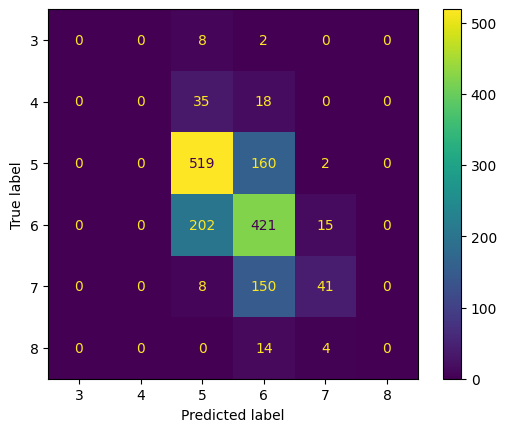

In [52]:
cm = confusion_matrix(y, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clases)
disp.plot()

### Primera Conclusión:
Observamos que las clases con pocas observaciones no han logrado ser clasificadas correctamente ni una sola vez. Al contrario de las superpobladas. A pesar de ello, se logró un scoring aceptable de aproxmadamente 0.61


In [53]:
#Modelo con XgBoost

le = LabelEncoder()
y_encoded = le.fit_transform(y)    

parametros = {
    'n_estimators' : [50, 100, 200],
    'max_depth' : [3,5,7],
    'learning_rate' : [0.1, 0.1, 0.2, 0.3]
}

modelo = XGBClassifier(random_state=42)
mi_grid = GridSearchCV(estimator = modelo, param_grid = parametros, cv =5, scoring='accuracy')

mi_grid.fit(X,y_encoded)

print("mejores parametros XGBoost: ", mi_grid.best_params_)
print("mejor score XGBoost: ", mi_grid.best_score_)


mejores parametros XGBoost:  {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50}
mejor score XGBoost:  0.5859913793103448


In [55]:
best_model = XGBClassifier(**mi_grid.best_params_, random_state=42)

kf = StratifiedKFold(n_splits=5, shuffle = True, random_state=42)

scores = cross_val_score(best_model, X,y_encoded, cv = kf, scoring='accuracy')

print("Accuracy promedio Random Forest: ", scores.mean())

Accuracy promedio Random Forest:  0.6291555642633229


In [57]:
y_pred_encoded = cross_val_predict(mi_grid.best_estimator_, X, y_encoded, cv=kf)
y_pred_original = le.inverse_transform(y_pred_encoded)


In [58]:
print("\nClassification Report:")
print(classification_report(y, y_pred_original))


Classification Report:
              precision    recall  f1-score   support

           3       1.00      0.10      0.18        10
           4       0.14      0.02      0.03        53
           5       0.68      0.77      0.72       681
           6       0.58      0.64      0.61       638
           7       0.59      0.38      0.46       199
           8       0.00      0.00      0.00        18

    accuracy                           0.63      1599
   macro avg       0.50      0.32      0.33      1599
weighted avg       0.61      0.63      0.61      1599



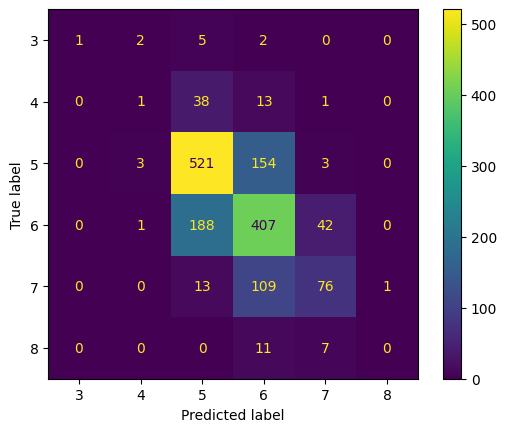

In [59]:
cm = confusion_matrix(y,y_pred_original)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clases)
disp.plot()

Vamos a reagrupar clases tratando de mejorar la distribucion de las muestras para intentar un mejor balance

In [72]:
reagrupo = {
    3: "Regular",
    4: "Regular",
    5: "Bueno",
    6: "Bueno",
    7: "Muy bueno",
    8: "Muy bueno"
}

# Aplicar el mapeo
y_reagrupado = pd.Series(np.array([reagrupo[val] for val in y]))

In [73]:
nuevas_clases = np.unique(y_reagrupado)

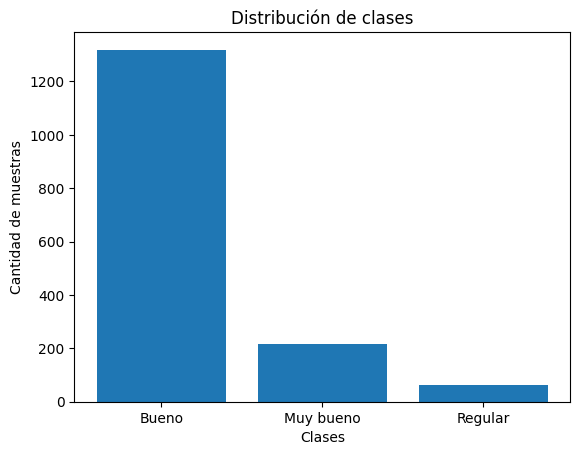

In [74]:
plt.bar(nuevas_clases, y_reagrupado.value_counts().sort_index())
plt.title("Distribución de clases")
plt.xlabel("Clases")
plt.ylabel("Cantidad de muestras")
plt.show()

Agrupando en 3 nuevas clases, no logramos mejorar significativamente el balance de los datos. Procedemos a separar el vino solo en bueno o malo

In [75]:
reagrupo = {
    3: "Regular",
    4: "Regular",
    5: "Regular",
    6: "Bueno",
    7: "Bueno",
    8: "Bueno"
}

# Aplicar el mapeo
y_reagrupado = pd.Series(np.array([reagrupo[val] for val in y]))

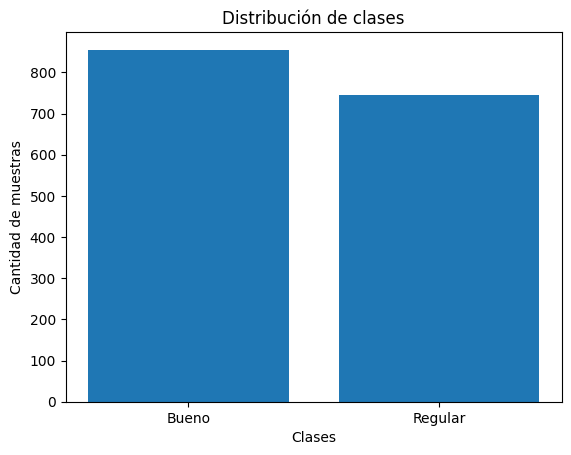

In [76]:
nuevas_clases = np.unique(y_reagrupado)
plt.bar(nuevas_clases, y_reagrupado.value_counts().sort_index())
plt.title("Distribución de clases")
plt.xlabel("Clases")
plt.ylabel("Cantidad de muestras")
plt.show()

In [80]:
"Limitamos los datos a dos clases: 'Regular' y 'Bueno' "

#Identificamos mejores parámetros para RanfomForest

model = RandomForestClassifier(random_state=42)

parametro = {
    'n_estimators' : [50, 100, 200],
    'max_depth' : [5,10,15],
    'min_samples_split' : [2,5,10]
}

mi_grid = GridSearchCV(estimator = model, 
                       param_grid = parametro, 
                       cv = 5, 
                       scoring='accuracy')

mi_grid.fit(X,y_reagrupado)

print("mejores parametros: ", mi_grid.best_params_)
print("mejor score: ", mi_grid.best_score_)



mejores parametros:  {'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 100}
mejor score:  0.7442260971786834


In [81]:
best_model = RandomForestClassifier(**mi_grid.best_params_, random_state=42)

kf = StratifiedKFold(n_splits=5, shuffle = True, random_state=42)

scores = cross_val_score(best_model, X,y_reagrupado, cv = kf, scoring='accuracy')

print("Accuracy promedio Random Forest: ", scores.mean())

Accuracy promedio Random Forest:  0.7641986677115988


In [82]:
# Predicciones globales para classification_report
y_pred = cross_val_predict(best_model, X, y_reagrupado, cv=kf)
print("\nClassification Report:")
print(classification_report(y_reagrupado, y_pred))


Classification Report:
              precision    recall  f1-score   support

       Bueno       0.79      0.77      0.78       855
     Regular       0.74      0.76      0.75       744

    accuracy                           0.76      1599
   macro avg       0.76      0.76      0.76      1599
weighted avg       0.76      0.76      0.76      1599



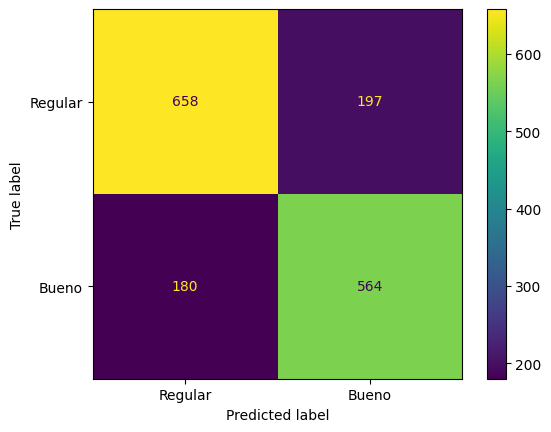

In [87]:
cm = confusion_matrix(y_reagrupado, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=y_reagrupado.unique())
disp.plot()

### Segunda Conclusión:
Observamos una notable mejoría al reducir el data set obteniendo un scoring de 0.76


In [88]:
#Modelo con XgBoost

le = LabelEncoder()
y_encoded = le.fit_transform(y_reagrupado)    

parametros = {
    'n_estimators' : [50, 100, 200],
    'max_depth' : [3,5,7],
    'learning_rate' : [0.1, 0.1, 0.2, 0.3]
}

modelo = XGBClassifier(random_state=42)
mi_grid = GridSearchCV(estimator = modelo, param_grid = parametros, cv =5, scoring='accuracy')

mi_grid.fit(X,y_encoded)

print("mejores parametros XGBoost: ", mi_grid.best_params_)
print("mejor score XGBoost: ", mi_grid.best_score_)

mejores parametros XGBoost:  {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
mejor score XGBoost:  0.7411030564263322


In [89]:
best_model = XGBClassifier(**mi_grid.best_params_, random_state=42)

kf = StratifiedKFold(n_splits=5, shuffle = True, random_state=42)

scores = cross_val_score(best_model, X,y_encoded, cv = kf, scoring='accuracy')

print("Accuracy promedio Random Forest: ", scores.mean())

Accuracy promedio Random Forest:  0.7573217084639499


In [90]:
y_pred_encoded = cross_val_predict(mi_grid.best_estimator_, X, y_encoded, cv=kf)
y_pred_original = le.inverse_transform(y_pred_encoded)

In [92]:
print("\nClassification Report:")
print(classification_report(y_reagrupado, y_pred_original))


Classification Report:
              precision    recall  f1-score   support

       Bueno       0.77      0.77      0.77       855
     Regular       0.74      0.74      0.74       744

    accuracy                           0.76      1599
   macro avg       0.76      0.76      0.76      1599
weighted avg       0.76      0.76      0.76      1599



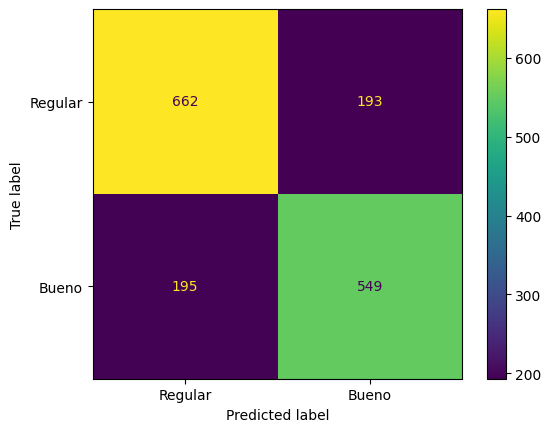

In [93]:
cm = confusion_matrix(y_reagrupado,y_pred_original)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=y_reagrupado.unique())
disp.plot()